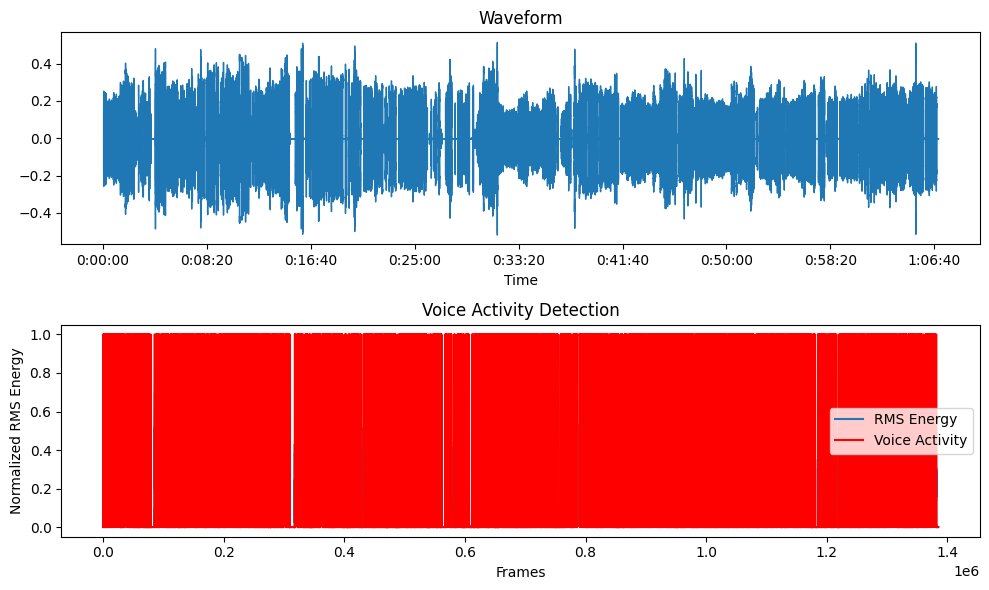

In [ ]:
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt


# def voice_activity_detection(audio_path, threshold=0.01):
#     # Load the audio file
#     y, sr = librosa.load(audio_path, sr=None)

#     # Compute the Short-Time Fourier Transform and Compute the magnitude of the STFT and Compute the root mean square (RMS) energy for each frame
#     rms = librosa.feature.rms(
#         S=np.abs(librosa.stft(y, n_fft=512)), frame_length=512, hop_length=128
#     )

#     # Normalize the RMS energy
#     rms_normalized = rms / np.max(rms)
#     del rms

#     # Detect voice activity based on the threshold
#     voice_activity = rms_normalized > threshold

#     # Plot the results
#     plt.figure(figsize=(21, 8), dpi=1000)
#     plt.subplot(2, 1, 1)
#     librosa.display.waveshow(y, sr=sr)
#     plt.title("Waveform")
#     plt.subplot(2, 1, 2)
#     plt.plot(rms_normalized[0], label="RMS Energy")
#     plt.plot(voice_activity[0], label="Voice Activity", color="r")
#     plt.title("Voice Activity Detection")
#     plt.xlabel("Frames")
#     plt.ylabel("Normalized RMS Energy")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return voice_activity


# # Example usage
# audio_path = "./vocals_only/test_1_vocals.wav"
# voice_activity = voice_activity_detection(audio_path)

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def voice_activity_detection(audio_path, threshold=0.01, min_silence_duration=1.5):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the Short-Time Fourier Transform and RMS energy
    rms = librosa.feature.rms(
        S=np.abs(librosa.stft(y, n_fft=512)), frame_length=512, hop_length=128
    )

    # Normalize the RMS energy
    rms_normalized = rms / np.max(rms)

    # Detect voice activity based on the threshold
    voice_activity = rms_normalized > threshold

    # Convert frame indices to time
    times = librosa.frames_to_time(
        np.arange(len(voice_activity[0])), sr=sr, hop_length=128
    )

    # Find intervals of voice activity
    intervals = []
    start_time = None
    for i, active in enumerate(voice_activity[0]):
        if active and start_time is None:
            start_time = times[i]
        elif not active and start_time is not None:
            end_time = times[i]
            intervals.append((start_time, end_time))
            start_time = None

    # Concatenate intervals with small gaps
    concatenated_intervals = []
    for start, end in intervals:
        if (
            concatenated_intervals
            and start - concatenated_intervals[-1][1] < min_silence_duration
        ):
            concatenated_intervals[-1] = (concatenated_intervals[-1][0], end)
        else:
            concatenated_intervals.append((start, end))

    # Prepare data for CSV
    data = []
    for start, end in concatenated_intervals:
        avg_energy = np.mean(
            rms_normalized[0][int(start * sr / 128) : int(end * sr / 128)]
        )
        data.append(
            {
                "Start": librosa.time_to_frames(start, sr=sr, hop_length=128),
                "End": librosa.time_to_frames(end, sr=sr, hop_length=128),
                "Energy": avg_energy,
                "Threshold": threshold,
            }
        )

    # Create a DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv("voice_activity_intervals.csv", index=False)

    # Plot the results
    plt.figure(figsize=(21, 8), dpi=1000)
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.subplot(2, 1, 2)
    plt.plot(rms_normalized[0], label="RMS Energy")
    plt.plot(voice_activity[0], label="Voice Activity", color="r")
    plt.title("Voice Activity Detection")
    plt.xlabel("Frames")
    plt.ylabel("Normalized RMS Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return voice_activity


# Example usage
audio_path = "./vocals_only/test_1_vocals.wav"
voice_activity = voice_activity_detection(audio_path)